In [35]:
import torch
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import nibabel as nib
from pathlib import Path
import numpy as np
from typing import Tuple
import torch.nn as nn
from tqdm import tqdm
from models.resnet import resnet10
import albumentations as A
import torch.nn.functional as F
from czifile import CziFile
from aicspylibczi import CziFile
import os
import random
import gc
import psutil

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## NOTE: I will show the steps for only for one 3D Time lapsed sample, I did this for each sample

In [7]:
czi_paths = [
    "MUT_Sample_New-01_AcquisitionBlock8.czi",
    # "MUT_New-01_AcquisitionBlock4.czi",
    # "MUT New-01_AcquisitionBlock2.czi",
    # "WT New-01_AcquisitionBlock4.czi",
    # "WT_Sample_New-01_AcquisitionBlock2.czi",
    # "WT New-01_AcquisitionBlock3.czi"
]

for czi_file in czi_paths:
    try:
        czi = CziFile(czi_file)
        axes = czi.axes  # e.g., 'TCZYX'
        shape = czi.shape

        dim_dict = dict(zip(axes, shape))
        x = dim_dict.get('X', None)
        y = dim_dict.get('Y', None)
        z = dim_dict.get('Z', None)
        t = dim_dict.get('T', None)
        c = dim_dict.get('C', None)

        print(f"\n{czi_file}")
        print(f" → Axes: {axes}")
        print(f" → Shape: {shape}")
        print(f" → X: {x}, Y: {y}, Z: {z}, T: {t}, C: {c}")
    except Exception as e:
        print(f"Error reading {czi_file}: {e}")


MUT_Sample_New-01_AcquisitionBlock8.czi
 → Axes: HSTCZYX0
 → Shape: (1, 1, 121, 1, 29, 1024, 1024, 1)
 → X: 1024, Y: 1024, Z: 29, T: 121, C: 1


In [8]:
# temporal part reduction
output_dir = Path("data/ZStacksWTMUT/IMAGESS")
output_dir.mkdir(parents=True, exist_ok=True)

nii_filenames = []

def get_WT_MUT(file):
    file = file.upper()
    if "WT" in file:
        return "WT"
    elif "MUT" in file:
        return "MUT"
    else:
        raise ValueError(f"Class label not specified: {file}")

counters = {'WT': 1, 'MUT': 1}

for file in czi_paths:
    label = get_WT_MUT(file)
    sample_id = f"{label}_Sample_{counters[label]:02d}"
    output_sample_dir = output_dir / sample_id
    output_sample_dir.mkdir(parents=True, exist_ok=True)

    try:
        czi = CziFile(file)
        data, shape_dict = czi.read_image()
    except Exception as e:
        print(f"Failed to load {file}: {e}")
        continue

    for t in range(shape_dict[2][1]):
        try:
            stack = data[0, 0, t, 0, :, :, :]
            stack = np.array(stack, dtype=np.float32)
            filename = f"t{t:03d}.nii.gz"
            nib.save(nib.Nifti1Image(stack, affine=np.eye(4)), output_sample_dir / filename)
            print(f"Saved: {output_sample_dir / filename}")
            del stack
            gc.collect()
        except Exception as e:
            print(f"Failed to process timepoint {t} in {file}: {e}")

    counters[label] += 1

Saved: data/ZStacksWTMUT/IMAGESS/MUT_Sample_01/t000.nii.gz
Saved: data/ZStacksWTMUT/IMAGESS/MUT_Sample_01/t001.nii.gz
Saved: data/ZStacksWTMUT/IMAGESS/MUT_Sample_01/t002.nii.gz
Saved: data/ZStacksWTMUT/IMAGESS/MUT_Sample_01/t003.nii.gz
Saved: data/ZStacksWTMUT/IMAGESS/MUT_Sample_01/t004.nii.gz
Saved: data/ZStacksWTMUT/IMAGESS/MUT_Sample_01/t005.nii.gz
Saved: data/ZStacksWTMUT/IMAGESS/MUT_Sample_01/t006.nii.gz
Saved: data/ZStacksWTMUT/IMAGESS/MUT_Sample_01/t007.nii.gz
Saved: data/ZStacksWTMUT/IMAGESS/MUT_Sample_01/t008.nii.gz
Saved: data/ZStacksWTMUT/IMAGESS/MUT_Sample_01/t009.nii.gz
Saved: data/ZStacksWTMUT/IMAGESS/MUT_Sample_01/t010.nii.gz
Saved: data/ZStacksWTMUT/IMAGESS/MUT_Sample_01/t011.nii.gz
Saved: data/ZStacksWTMUT/IMAGESS/MUT_Sample_01/t012.nii.gz
Saved: data/ZStacksWTMUT/IMAGESS/MUT_Sample_01/t013.nii.gz
Saved: data/ZStacksWTMUT/IMAGESS/MUT_Sample_01/t014.nii.gz
Saved: data/ZStacksWTMUT/IMAGESS/MUT_Sample_01/t015.nii.gz
Saved: data/ZStacksWTMUT/IMAGESS/MUT_Sample_01/t016.nii.

In [ ]:
image_root = Path("data/ZStacksWTMUT/IMAGESS")
nii_filenames = list(image_root.glob("**/*.nii.gz"))

np.random.seed(42)
np.random.shuffle(nii_filenames)

split = int(0.8 * len(nii_filenames))
train_list = nii_filenames[:split]
val_list = nii_filenames[split:]

def extract_label(path):
    name = str(path).upper()
    if "MUT" in name:
        return 1
    elif "WT" in name:
        return 0
    else:
        raise ValueError(f"Unknown class label in: {path}")

def write_split(filename, split_list):
    Path(filename).parent.mkdir(parents=True, exist_ok=True)  
    with open(filename, "w") as f:
        for path in split_list:
            label = extract_label(path)
            rel_path = path.relative_to("data") 
            f.write(f"{rel_path} {label}\n")

write_split("data/ZStacksWTMUT/TRAIN_FINAL.txt", train_list)
write_split("data/ZStacksWTMUT/TEST_FINAL.txt", val_list)

print("✅ TRAIN_FINAL.txt and TEST_FINAL.txt written correctly.")
# I CREATED A .TXT FILE CALLED ALLL.TXT AND COPY PASTED THE PATHS FROM TRAIN_FINAL.txt and TEST_FINAL.txt TO ALLL.txt FILE.

✅ TRAIN_FINAL.txt and TEST_FINAL.txt written correctly.


Shape of volume: (29, 1024, 1024)


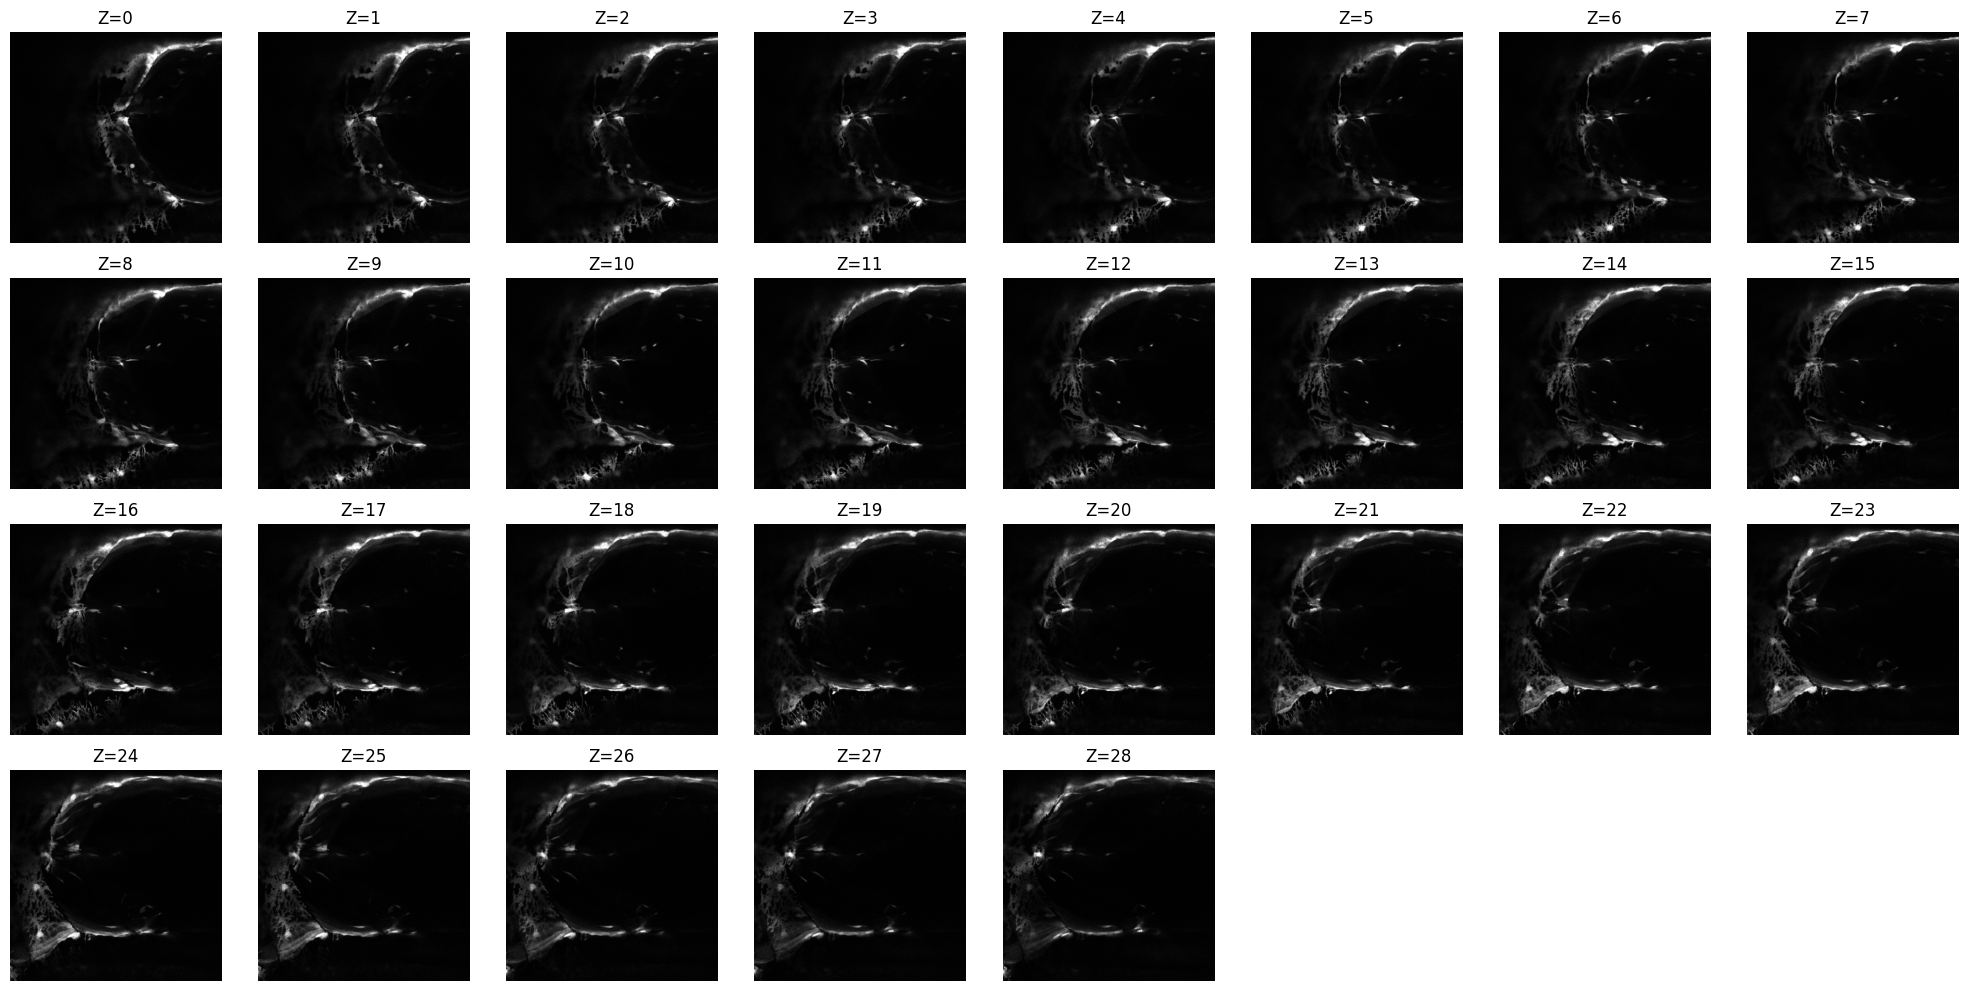

In [13]:
# visulasing a time independent z stack: 
sample_path = Path("data/ZStacksWTMUT/IMAGESS/MUT_Sample_01/t006.nii.gz") 
img = nib.load(str(sample_path))
data = img.get_fdata()  # Shape: [Z, Y, X]

print(f"Shape of volume: {data.shape}")
num_slices = data.shape[0]


cols = 8  
rows = int(np.ceil(num_slices / cols))
fig, axes = plt.subplots(rows, cols, figsize=(20, 2.5 * rows))

for z in range(num_slices):
    r, c = divmod(z, cols)
    ax = axes[r, c]
    ax.imshow(data[z, :, :], cmap='gray')
    ax.set_title(f"Z={z}")
    ax.axis('off')

for z in range(num_slices, rows * cols):
    r, c = divmod(z, cols)
    axes[r, c].axis('off')

plt.tight_layout()
plt.show()

In [14]:
# DATALOADER CLASS:

class CustomDataset(Dataset):  
    def __init__(self, txt_file, base_dir=Path("."), transform=None, fixed_depth=32):
        self.paths = []
        self.transform = transform
        self.fixed_depth = fixed_depth

        with open(txt_file, "r") as f:
            for line in f:
                relative_path, label = line.strip().split()
                full_path = base_dir / relative_path
                self.paths.append((full_path, int(label)))

    def __getitem__(self, idx):
        file_path, label = self.paths[idx]
        zstack = nib.load(file_path)
        data = zstack.get_fdata().astype(np.float32)

        # Log normalization + Min-Max
        data = np.log1p(data)
        data_min, data_max = data.min(), data.max()
        data = (data - data_min) / (data_max - data_min) if data_max > data_min else np.zeros_like(data)

        # Padding or Cropping Depth (D)
        current_depth = data.shape[0]
        if current_depth < self.fixed_depth:
            pad_front = (self.fixed_depth - current_depth) // 2
            pad_back = self.fixed_depth - current_depth - pad_front
            data = np.pad(data, ((pad_front, pad_back), (0, 0), (0, 0)), mode='constant', constant_values=0)
        elif current_depth > self.fixed_depth:
            start = (current_depth - self.fixed_depth) // 2
            data = data[start:start + self.fixed_depth, :, :]

        data = torch.tensor(data).unsqueeze(0)

        if self.transform:
            subject = self.transform(subject)
            data = subject['image'].data

        # Resize height & width only (not depth anymore)
        data = F.interpolate(
            data.unsqueeze(0), size=(self.fixed_depth, 256, 256),
            mode='trilinear', align_corners=False
        ).squeeze(0)

        label = torch.tensor(label, dtype=torch.float32)
        return data, label

    def __len__(self):
        return len(self.paths)

Data shape: torch.Size([4, 1, 32, 256, 256])
Labels shape: torch.Size([4])


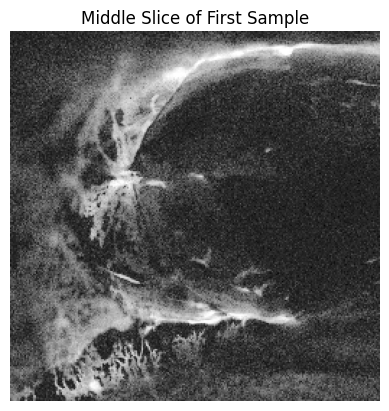

In [17]:
dataset = CustomDataset(
    txt_file="data/ZStacksWTMUT/ALLL.txt", 
    base_dir=Path("data/"),
    transform=None
)

loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

batch = next(iter(loader))
data, labels = batch

print("Data shape:", data.shape) 
print("Labels shape:", labels.shape)

sample = data[0]
slice_idx = sample.shape[1] // 2 
slice_img = sample[0, slice_idx, :, :].numpy()

plt.imshow(slice_img, cmap='gray')
plt.title("Middle Slice of First Sample")
plt.axis('off')
plt.show()

Original shape: torch.Size([4, 1, 35, 256, 256])
Aug1 shape: torch.Size([4, 1, 35, 256, 256])
Aug2 shape: torch.Size([4, 1, 35, 256, 256])
Labels shape: torch.Size([4])


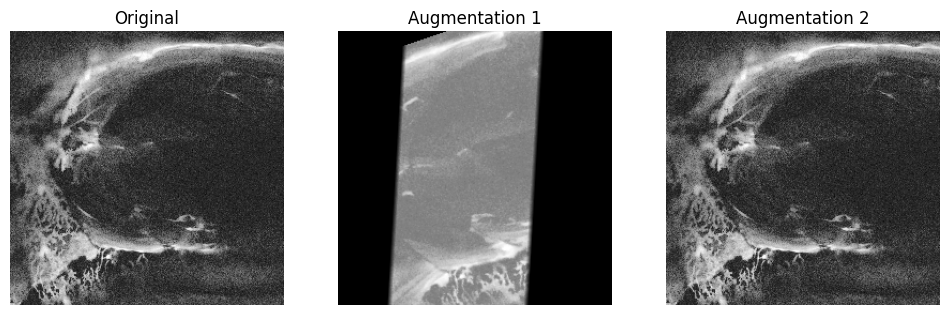

In [20]:
import torchio as tio
# FOR CREATING 2 AUGMENTED VIEWS OF EACH ORIGINAL SAMPLE : 
class CustomAugmentedDataset(Dataset):
    def __init__(self, txt_file, base_dir=Path("."), fixed_depth=35):
        self.paths = []
        self.fixed_depth = fixed_depth
        self.base_dir = base_dir

        with open(txt_file, "r") as f:
            for line in f:
                relative_path, label = line.strip().split()
                full_path = base_dir / relative_path
                self.paths.append((full_path, int(label)))

       
        self.augmentation = tio.Compose([
            tio.RandomAffine(scales=(0.9, 1.1), degrees=20, translation=7, p=0.75),
            tio.RandomNoise(mean=0.0, std=0.05, p=0.1),
            tio.RandomBlur(p=0.1)
        ])

    def __getitem__(self, idx):
        file_path, label = self.paths[idx]

        try:
            zstack = nib.load(str(file_path))
            data = zstack.get_fdata().astype(np.float32)
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
            data = np.zeros((self.fixed_depth, 256, 256), dtype=np.float32)

        # Normalize using log1p and min-max scaling
        data = np.log1p(data)
        data_min, data_max = data.min(), data.max()
        if data_max > data_min:
            data = (data - data_min) / (data_max - data_min)
        else:
            data = np.zeros_like(data)

        # Pad or crop depth to fixed_depth
        current_depth = data.shape[0]
        if current_depth < self.fixed_depth:
            pad_front = (self.fixed_depth - current_depth) // 2
            pad_back = self.fixed_depth - current_depth - pad_front
            data = np.pad(data, ((pad_front, pad_back), (0,0), (0,0)), mode='constant', constant_values=0)
        elif current_depth > self.fixed_depth:
            # Crop center slices
            start = (current_depth - self.fixed_depth) // 2
            data = data[start:start + self.fixed_depth, :, :]

        data = torch.tensor(data).unsqueeze(0)

        data = F.interpolate(data.unsqueeze(0), size=(self.fixed_depth, 256, 256), mode='trilinear', align_corners=False).squeeze(0)

        
        subject = tio.Subject(image=tio.ScalarImage(tensor=data))

        # Apply two independent augmentations
        aug1 = self.augmentation(subject)['image'].data
        aug2 = self.augmentation(subject)['image'].data

        label = torch.tensor(label, dtype=torch.float32)

        return data, aug1, aug2, label

    def __len__(self):
        return len(self.paths)
        
dataset = CustomAugmentedDataset(
    txt_file="data/ZStacksWTMUT/ALLL.txt", 
    base_dir=Path("data/"),
)

loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)


original, aug1, aug2, labels = next(iter(loader))

print("Original shape:", original.shape)
print("Aug1 shape:", aug1.shape)
print("Aug2 shape:", aug2.shape)
print("Labels shape:", labels.shape)


sample_idx = 0
slice_idx = original.shape[2] // 2  # Middle depth slice (D = 32)

def show_sample(data, title):
    img = data[sample_idx, 0, slice_idx, :, :].numpy()
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
show_sample(original, "Original")

plt.subplot(1, 3, 2)
show_sample(aug1, "Augmentation 1")

plt.subplot(1, 3, 3)
show_sample(aug2, "Augmentation 2")

plt.show()

In [23]:
output_dir = Path("data/ZStacksWTMUT/AUGMENT_IMGAGESS")
output_dir.mkdir(exist_ok=True, parents=True)


dataset = CustomAugmentedDataset(
    txt_file="data/ZStacksWTMUT/ALLL.txt",
    base_dir=Path("data/")
)

for idx in range(len(dataset)):
    orig, aug1, aug2, label = dataset[idx]

    
    aug1_np = aug1.squeeze(0).numpy()
    aug2_np = aug2.squeeze(0).numpy()

    
    orig_path, _ = dataset.paths[idx]
    rel_path = orig_path.relative_to(Path("data"))
    sample_folder = rel_path.parent.name 
    base_name = rel_path.stem       

    sample_output_dir = output_dir / sample_folder
    sample_output_dir.mkdir(exist_ok=True, parents=True)

    # Save aug1
    aug1_nii = nib.Nifti1Image(aug1_np, affine=np.eye(4))
    aug1_path = sample_output_dir / f"{base_name}_aug1.nii.gz"
    nib.save(aug1_nii, aug1_path)

    # Save aug2
    aug2_nii = nib.Nifti1Image(aug2_np, affine=np.eye(4))
    aug2_path = sample_output_dir / f"{base_name}_aug2.nii.gz"
    nib.save(aug2_nii, aug2_path)

    print(f"✅ Saved: {aug1_path.name}, {aug2_path.name}")

✅ Saved: t006.nii_aug1.nii.gz, t006.nii_aug2.nii.gz
✅ Saved: t052.nii_aug1.nii.gz, t052.nii_aug2.nii.gz
✅ Saved: t115.nii_aug1.nii.gz, t115.nii_aug2.nii.gz
✅ Saved: t051.nii_aug1.nii.gz, t051.nii_aug2.nii.gz
✅ Saved: t083.nii_aug1.nii.gz, t083.nii_aug2.nii.gz
✅ Saved: t017.nii_aug1.nii.gz, t017.nii_aug2.nii.gz
✅ Saved: t003.nii_aug1.nii.gz, t003.nii_aug2.nii.gz
✅ Saved: t037.nii_aug1.nii.gz, t037.nii_aug2.nii.gz
✅ Saved: t072.nii_aug1.nii.gz, t072.nii_aug2.nii.gz
✅ Saved: t018.nii_aug1.nii.gz, t018.nii_aug2.nii.gz
✅ Saved: t106.nii_aug1.nii.gz, t106.nii_aug2.nii.gz
✅ Saved: t057.nii_aug1.nii.gz, t057.nii_aug2.nii.gz
✅ Saved: t067.nii_aug1.nii.gz, t067.nii_aug2.nii.gz
✅ Saved: t080.nii_aug1.nii.gz, t080.nii_aug2.nii.gz
✅ Saved: t049.nii_aug1.nii.gz, t049.nii_aug2.nii.gz
✅ Saved: t026.nii_aug1.nii.gz, t026.nii_aug2.nii.gz
✅ Saved: t094.nii_aug1.nii.gz, t094.nii_aug2.nii.gz
✅ Saved: t060.nii_aug1.nii.gz, t060.nii_aug2.nii.gz
✅ Saved: t071.nii_aug1.nii.gz, t071.nii_aug2.nii.gz
✅ Saved: t05

In [24]:
augmented_root = Path("data/ZStacksWTMUT/AUGMENT_IMGAGESS")
output_txt = Path("data/ZStacksWTMUT/AUGMENTED_ALLL.txt")

nii_files = list(augmented_root.glob("**/*.nii.gz"))

with open(output_txt, "w") as f:
    for path in nii_files:
        path_str = path.relative_to("data")  
        name = str(path).upper()
        
        if "MUT" in name:
            label = 1
        elif "WT" in name:
            label = 0
        else:
            raise ValueError(f"Unknown class label in path: {path}")

        f.write(f"{path_str} {label}\n")

print(f"✅ Written {len(nii_files)} augmented paths to {output_txt}")

✅ Written 242 augmented paths to data/ZStacksWTMUT/AUGMENTED_ALLL.txt


#### AT THEN END 
- I COPIED THE AUGMENTED PATHS FROM  'data/ZStacksWTMUT/AUGMENTED_ALLL.txt'
- PASTED TO 'data/ZStacksWTMUT/ALLL.txt'
- REMOVED 25 SAMPLES FROM 'data/ZStacksWTMUT/ALLL.txt' AND WROTE IT ON 'data/ZStacksWTMUT/test.txt'
- data/ZStacksWTMUT/ALLL.txt = train+val set and data/ZStacksWTMUT/test.txt = held out set

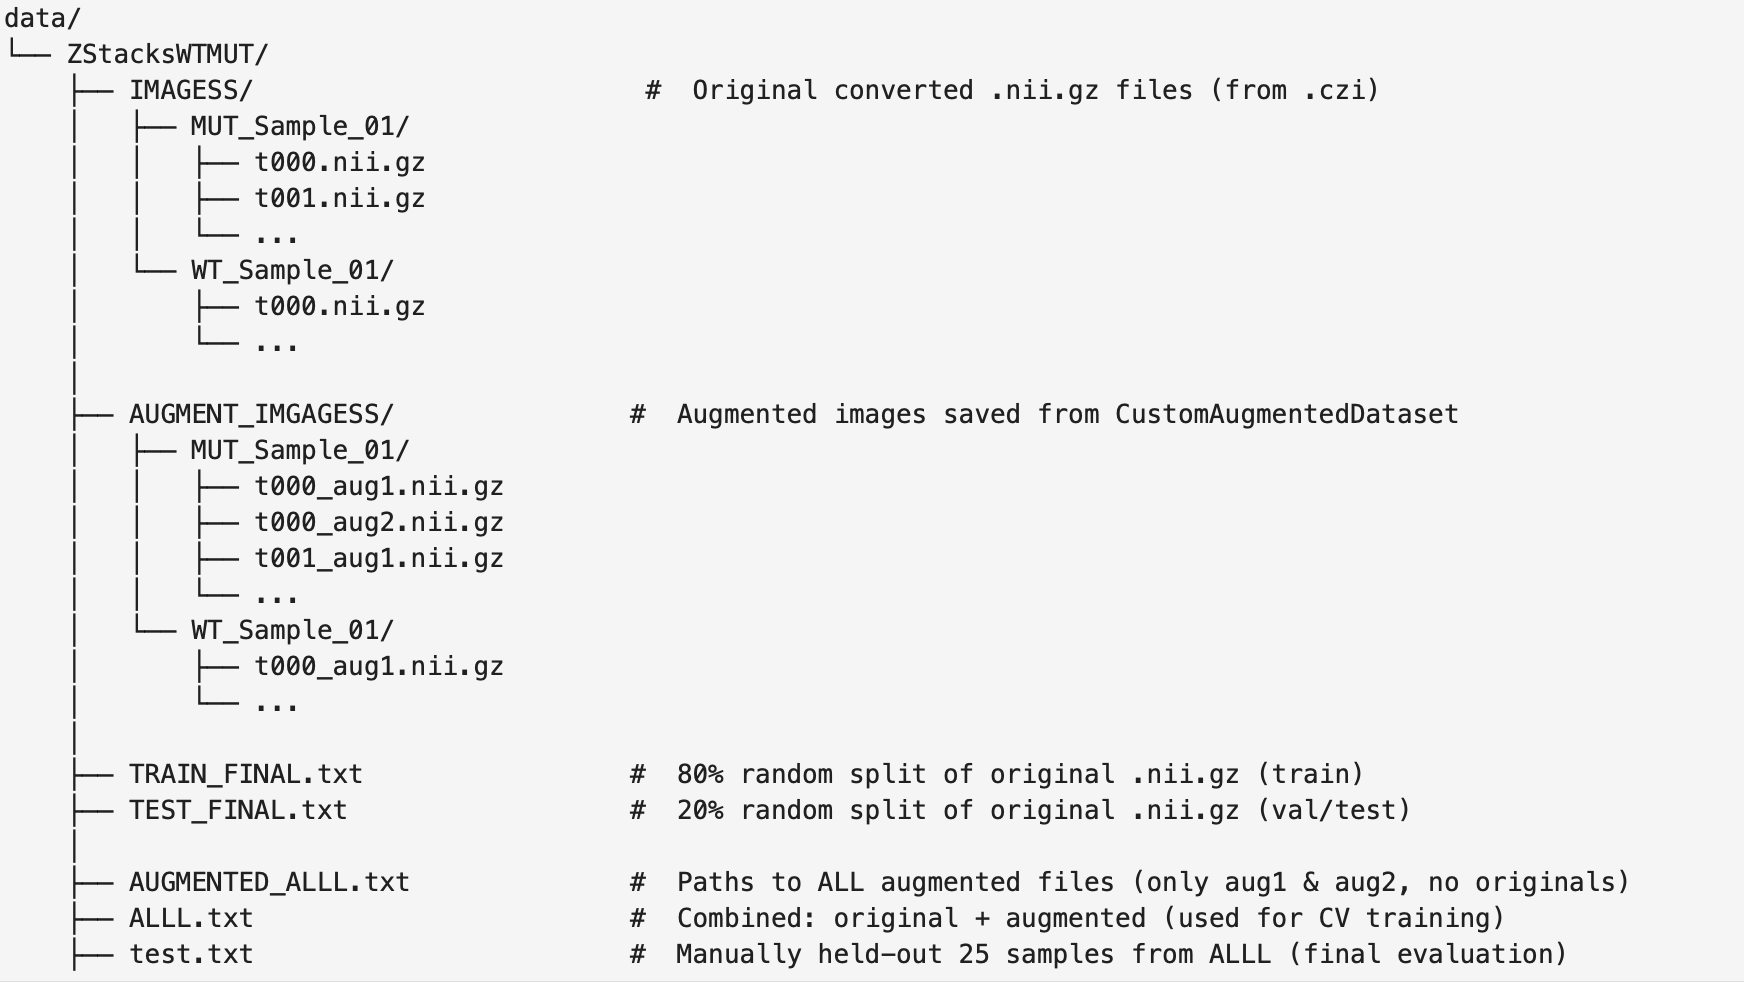